In [1]:
import numpy as np

data = np.load("../embeddings/embeddings_2025-05-29_14-30-47.npz", allow_pickle=True)

db_embeddings = data["db_embeddings"]
db_labels_bin = data["db_labels"]
db_paths = data["db_path"]
query_embeddings = data["query_embeddings"]

db_labels = np.array([data['class_mapping'].item()[i] for i in db_labels_bin])

In [2]:
data

NpzFile '../embeddings/embeddings_2025-05-29_14-30-47.npz' with keys: db_embeddings, db_labels, db_path, query_embeddings, query_labels...

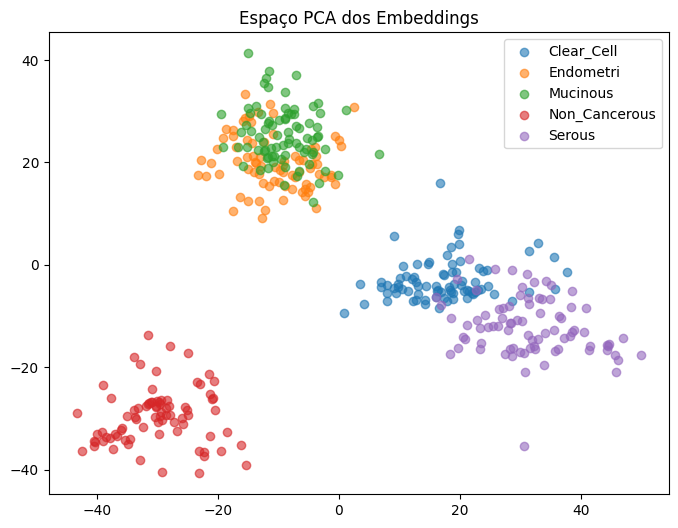

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
db_proj = pca.fit_transform(db_embeddings)

plt.figure(figsize=(8, 6))
for label in np.unique(db_labels):
    idxs = db_labels == label
    plt.scatter(db_proj[idxs, 0], db_proj[idxs, 1], label=label, alpha=0.6)
plt.title("Espaço PCA dos Embeddings")
plt.legend()
plt.show()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, db_embeddings, db_labels, cv=5)
print(f"Acurácia média (Probing): {scores.mean():.2f}")

Acurácia média (Probing): 0.98


Acurácia:  0.98
Precisão:  0.98
Recall:    0.97
F1-Score:  0.98

Relatório completo:

                  precision    recall  f1-score   support

        Crescent       0.98      0.98      0.98      1180
Hypercellularity       0.98      0.98      0.98      2048
      Membranous       0.98      0.99      0.99      1608
          Normal       0.99      0.98      0.99      1570
   Podocytopathy       0.97      0.95      0.96       547
       Sclerosis       0.95      0.96      0.95       613

        accuracy                           0.98      7566
       macro avg       0.98      0.97      0.98      7566
    weighted avg       0.98      0.98      0.98      7566



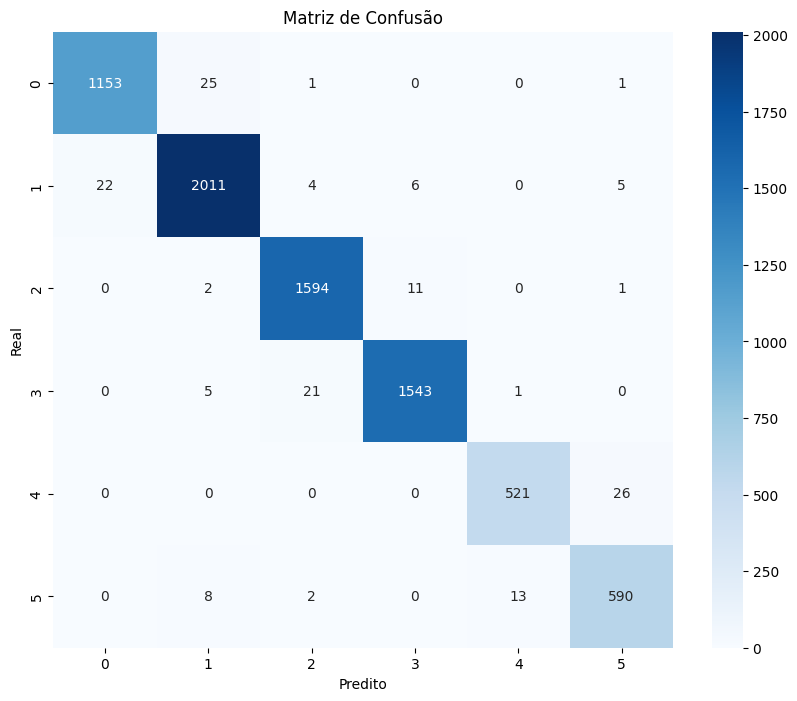

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Classificador simples (probe)
clf = LogisticRegression(max_iter=1000)

# Faz predições com validação cruzada (5-fold)
y_pred = cross_val_predict(clf, db_embeddings, db_labels, cv=5)

# Métricas de avaliação
accuracy = accuracy_score(db_labels, y_pred)
precision = precision_score(db_labels, y_pred, average='macro')  # ou 'weighted'
recall = recall_score(db_labels, y_pred, average='macro')
f1 = f1_score(db_labels, y_pred, average='macro')

print(f"Acurácia:  {accuracy:.2f}")
print(f"Precisão:  {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-Score:  {f1:.2f}")
print("\nRelatório completo:\n")
print(classification_report(db_labels, y_pred))

# Matriz de confusão
cm = confusion_matrix(db_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [9]:
from sklearn.metrics.pairwise import cosine_distances

def get_top_k(query_emb, db_embs, k=5):
    dists = cosine_distances(query_emb.reshape(1, -1), db_embs).flatten()
    top_k = np.argsort(dists)[:k]
    return top_k, dists[top_k]

query_id = 20

top_ids, top_dists = get_top_k(query_embeddings[query_id], db_embeddings, k=10)
for i, idx in enumerate(top_ids):
    print(f"{i+1}. {db_paths[idx]} (dist={top_dists[i]:.4f})")

1. datasets/final/glomerulo/train/Crescent/Terumo_Crescent_PAS/975952.jpeg (dist=0.1248)
2. datasets/final/glomerulo/train/Crescent/Terumo_Crescent_PAS/987195.jpeg (dist=0.1275)
3. datasets/final/glomerulo/train/Hypercellularity/Terumo_Hypercelularidade_HE/2626241.jpeg (dist=0.1276)
4. datasets/final/glomerulo/train/Hypercellularity/Terumo_Hypercelularidade_HE/2601785.jpeg (dist=0.1282)
5. datasets/final/glomerulo/train/Hypercellularity/Terumo_Hypercelularidade_PAS/2666462.jpeg (dist=0.1385)
6. datasets/final/glomerulo/train/Hypercellularity/Terumo_Hypercelularidade_PAS/2666537.jpeg (dist=0.1419)
7. datasets/final/glomerulo/train/Crescent/Terumo_Crescent_PAS/956965.jpeg (dist=0.1419)
8. datasets/final/glomerulo/train/Hypercellularity/Terumo_Hypercelularidade_PAS/2502753.jpeg (dist=0.1428)
9. datasets/final/glomerulo/train/Hypercellularity/Terumo_Hypercelularidade_PAS/2525584.jpeg (dist=0.1433)
10. datasets/final/glomerulo/train/Crescent/Terumo_Crescent_PAS/967003.jpeg (dist=0.1458)


In [21]:
import torch
import timm
import torchvision.transforms as T
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
use_vit = True  # ou False para ResNet + Grad-CAM

if use_vit:
    model = timm.create_model("vit_base_patch16_224", pretrained=True).to(device)
else:
    model = timm.create_model("resnet50", pretrained=True).to(device)

model.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c108ListType3getERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEENS_4Type24SingletonOrSharedTypePtrIS9_EE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [22]:
def vit_attention_rollout(model, img_tensor):
    attn_blocks = [blk.attn.attn_drop for blk in model.blocks]
    img_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        _ = model.forward_features(img_tensor)

    attn = model.blocks[-1].attn.get_attn()
    attn = attn[0].mean(0)
    mask = attn[0, 1:].reshape(14, 14).cpu().numpy()
    return mask

In [23]:
from torchvision.models.feature_extraction import create_feature_extractor

def gradcam_resnet(model, img_tensor):
    model.eval()
    features = {}

    def hook_fn(m, i, o): features["feat"] = o

    handle = model.layer4.register_forward_hook(hook_fn)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    model(img_tensor)
    act = features["feat"].squeeze(0).mean(0).cpu().numpy()
    handle.remove()
    return act

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_explainability(img_path, use_vit=True):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)

    if use_vit:
        mask = vit_attention_rollout(model, img_tensor)
        mask = cv2.resize(mask, img.size)
    else:
        mask = gradcam_resnet(model, img_tensor)
        mask = cv2.resize(mask, img.size)

    mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask) + 1e-8)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.array(img) * 0.5 + heatmap * 0.5

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Imagem original")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Mapa de atenção")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(overlay.astype(np.uint8))
    plt.title("Sobreposição")
    plt.axis("off")
    plt.show()

visualize_explainability("../datasets/final/glomerulo/train/Membranous/Terumo_Membranous_HE/2467160.jpeg", use_vit=True)

AttributeError: 'Attention' object has no attribute 'get_attn'

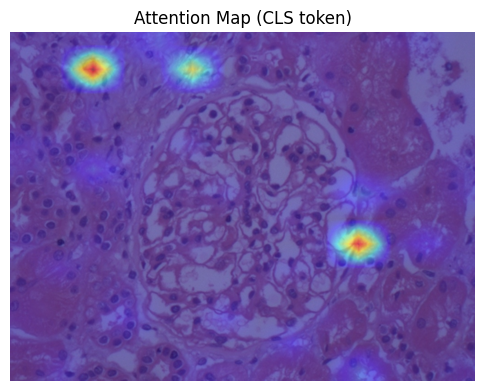

In [31]:
import torch
import timm
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2

# Carrega modelo ViT do timm
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.eval()

# Lista para armazenar a atenção
attn_weights = []

# Define o hook no método forward da Attention
def hook_fn(module, input, output):
    # input[0] -> x (B, tokens, dim)
    # queremos calcular manualmente a atenção bruta
    qkv = module.qkv(input[0])  # (B, tokens, 3 * dim)
    B, N, _ = qkv.shape
    qkv = qkv.reshape(B, N, 3, module.num_heads, module.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]  # cada um (B, heads, tokens, head_dim)

    attn = (q @ k.transpose(-2, -1)) * module.scale  # (B, heads, tokens, tokens)
    attn = attn.softmax(dim=-1)
    attn_weights.append(attn.detach())

# Registra hook na última camada de atenção
hook = model.blocks[-1].attn.register_forward_hook(hook_fn)

# Transforma imagem
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Função de visualização
def show_attention_map(image_path):
    global attn_weights
    attn_weights = []

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        _ = model(img_tensor)

    if not attn_weights:
        print("❌ Nenhum mapa de atenção capturado.")
        return

    attn = attn_weights[0]  # (B, heads, tokens, tokens)
    attn = attn.mean(1)     # média entre heads → (B, tokens, tokens)
    cls_attn = attn[0, 0, 1:]  # atenção do token [CLS] para os patches

    # Reshape em grade
    num_patches = cls_attn.shape[0]
    grid_size = int(np.sqrt(num_patches))
    mask = cls_attn.reshape(grid_size, grid_size).cpu().numpy()
    mask = cv2.resize(mask, image.size)
    mask = (mask - mask.min()) / (mask.max() - mask.min())

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.title("Attention Map (CLS token)")
    plt.axis("off")
    plt.show()

# 🔍 Teste com sua imagem
show_attention_map("../datasets/final/glomerulo/train/Normal/Terumo_Normal_HE/2414115.jpeg")

# ⛔ Remova hook quando não precisar mais
hook.remove()
